In [1]:
from CEG import CEG_analysis
from utility_funcs import get_folds, scale_data, get_train_test, get_RMSE

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline

## Load that data!

In [27]:
# patient suffixes for file names
mayo_suffs = ['001','002','003','004','005','006','007','008']
sans_suffs = ['01','02','03','04','05','06','07','08','09','10']
data_bypat = {} # holder for data seperated by patient

# loading the data from the pickle files
for s, suff in enumerate(sans_suffs):
    filename = 'feature_data/sansum-%s.p' % suff
    data_bypat['s%s' % (s+1)] = pickle.load(open(filename,'rb'))
    data_bypat['s%s' % (s+1)] = data_bypat['s%s' % (s+1)].fillna(data_bypat['s%s' % (s+1)].mean())
    data_bypat['s%s' % (s+1)] = data_bypat['s%s' % (s+1)].loc[:,['BG0', 'BG_PH', 'BGday_var', 'dBG30', 'dBG60','eda0','hr0','step0','t0','temp0']]
    
    
for m, suff in enumerate(mayo_suffs):
    filename = 'feature_data/mayo-%s.p' % suff
    data_bypat['m%s' % (m+1)] = pickle.load(open(filename,'rb'))
    data_bypat['m%s' % (m+1)] = data_bypat['m%s' % (m+1)].fillna(data_bypat['m%s' % (m+1)].mean())
    data_bypat['m%s' % (m+1)] = data_bypat['m%s' % (m+1)].loc[:,['BG0', 'BG_PH', 'BGday_var', 'dBG30', 'dBG60','eda0','hr0','step0','t0','temp0']]

In [28]:
data_bypat['m4'].columns # ensure data was properly imported

Index(['BG0', 'BG_PH', 'BGday_var', 'dBG30', 'dBG60', 'eda0', 'hr0', 'step0',
       't0', 'temp0'],
      dtype='object')

## Model build and optimization


In [29]:
kerns = ['linear', 'poly', 'rbf'] # kernal types to try
poly_degs = [3]# , 5, 10] # polynomial degrees
Es = [.01, .1, .25, .5, 1] # epsilon values
folds = get_folds(data_bypat) # get folds
cv_means = np.zeros([len(kerns)-1+len(poly_degs), len(Es)]) # holder for cv scores
cv_stds = np.zeros([len(kerns)-1+len(poly_degs), len(Es)]) # holder for stds of cv scores

In [30]:
# due to very long execution time, only one validation set can be used at this time
m = 0 # keep track of index corresponding to kernel/poly degree combo
for kern in kerns:
    print(kern)
    if kern == 'poly':
        for deg in poly_degs:
            print(kern, deg)
            for e,epsilon in enumerate(Es):
                print(epsilon, end=', ')

                # train test split / data process
                test_y, test_x, train_y, train_x, scaler = get_train_test(data_bypat,folds,0)

                # train, fit, evaluate the model
                svr_model = SVR(kernel=kern, degree=deg, epsilon=epsilon,cache_size=1000)
                svr_model.fit(train_x,train_y)
                #cvs_cur.append(svr_model.score(test_x,test_y))
                
                # update cv means and stds
                cv_means[m,e] = mean_squared_error(test_y, svr_model.predict(test_x))
                print(cv_means)
            m = m+1
    else:
        for e,epsilon in enumerate(Es):
            print(epsilon, end=', ')
            # train test split / data process
            test_y, test_x, train_y, train_x, scaler = get_train_test(data_bypat,folds,0)
            print('split', end=' ')
            # train, fit, evaluate the model
            svr_model = SVR(kernel=kern, epsilon=epsilon, cache_size=1000)
            print('modelled', end=' ')
            svr_model.fit(train_x,train_y)
            print('fit')
            # update cv means and stds
            cv_means[m,e] = mean_squared_error(test_y, svr_model.predict(test_x))
            print(cv_means)
            #cv_stds[m,e] = np.std(cvs_cur)
        m = m+1
                


linear
0.01, split modelled fit
[[691.62175886   0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]]
0.1, split modelled fit
[[691.62175886 691.66125412   0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]]
0.25, split modelled fit
[[691.62175886 691.66125412 691.61734993   0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]]
0.5, split modelled fit
[[691.62175886 691.66125412 691.61734993 691.76774577   0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]]
1, split modelled fit
[[691.62175886 691.66125412 691.61734993 691.76774577

In [ ]:
train_x.shape


In [31]:
cv_means

array([[ 691.62175886,  691.66125412,  691.61734993,  691.76774577,
         691.4646928 ],
       [2425.12189765, 2427.27264308, 2431.18988442, 2430.30215925,
        2432.87161947],
       [ 893.45404981,  893.49536476,  893.53451423,  893.15881132,
         892.33705506]])

In [ ]:
1==2

In [32]:
np.sqrt(cv_means)

array([[26.29870261, 26.29945349, 26.29861878, 26.30147801, 26.29571624],
       [49.24552668, 49.2673588 , 49.30709771, 49.29809488, 49.32414844],
       [29.89070173, 29.89139282, 29.89204768, 29.88576269, 29.87201123]])

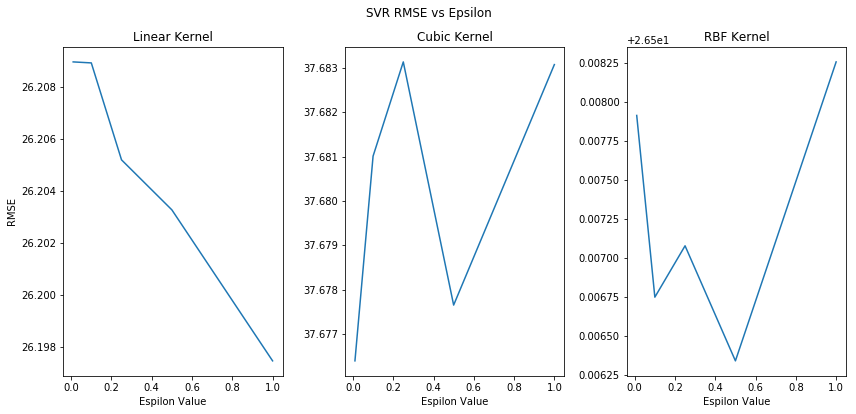

In [23]:
plt.figure(figsize=[12,6])
plt.suptitle('SVR RMSE vs Epsilon')
plt.subplot(1,3,1)
plt.plot(Es,np.sqrt(cv_means[0,:]))
plt.title('Linear Kernel')
plt.ylabel('RMSE')
plt.xlabel('Espilon Value')
plt.subplot(1,3,2)
plt.plot(Es,np.sqrt(cv_means[1,:]))
plt.title('Cubic Kernel')
plt.xlabel('Espilon Value')
plt.subplot(1,3,3)
plt.plot(Es,np.sqrt(cv_means[2,:]))
plt.title('RBF Kernel')
plt.xlabel('Espilon Value')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])